## Package install

In [277]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
torch.__version__

'2.8.0+cu126'

In [278]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [279]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed()

## Data input and Processing

In [280]:
import pandas as pd
df = pd.read_excel("/kaggle/input/tc-data/TC_Data_xl.xlsx","lagged")

df.head()

,aet,ppt,ro,srad,soilm,tavg,wa,wa_t-1
0,85.9761,161.8611,0.0000,173.3156,62.2907,19.99850,16.0776,26.21
1,42.5546,0.4066,0.0000,192.7015,45.2816,21.09425,15.5862,16.07
2,30.8881,0.0000,1.0000,210.6888,35.6984,24.84405,14.2065,15.58
3,10.2085,14.6163,0.0000,259.2214,29.5871,31.03615,0.0000,14.20
4,16.1381,1.0000,0.6384,286.2422,25.3212,32.56040,0.0000,17.16


In [281]:
df.columns

Index(['aet', 'ppt', 'ro', 'srad', 'soilm', 'tavg', 'wa', 'wa_t-1'], dtype='object')

In [282]:
X = df.drop(columns=['wa', 'ro', 'srad']).to_numpy()

y = df['wa'].to_numpy().reshape(384,1)

In [283]:
import numpy as np
idx_y_zero = np.where(y==0)[0]
idx_y_nonzero = np.where(y!=0)[0]
y_non_zero = y[idx_y_nonzero].reshape(-1,1)
X_non_zero = X[idx_y_nonzero]

In [284]:
len(idx_y_zero)

125

In [285]:
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler()
scalerY = StandardScaler()
scaled_X = scalerX.fit_transform(X)
scaled_y_non_zero = scalerY.fit_transform(y_non_zero.reshape(-1,1))
scaled_X_non_zero = scaled_X[idx_y_nonzero]


In [286]:
indices = np.arange(len(y_non_zero))
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
   scaled_X_non_zero,scaled_y_non_zero, indices, test_size = 0.25, shuffle = True, random_state = 42)

In [287]:
torch_X_train = torch.from_numpy(X_train).type(torch.float32).to(device)
torch_X_test = torch.from_numpy(X_test).type(torch.float32).to(device)

torch_y_train = torch.from_numpy(y_train).type(torch.float32).to(device)
torch_y_test = torch.from_numpy(y_test).type(torch.float32).to(device)


## Model Architeture -FNN

In [288]:
class LinearReg(nn.Module):
    def __init__(self, input_size, num_classes, hidden_layers):
        super(LinearReg, self).__init__()
        layers = []
        in_features = input_size

        # Add hidden layers dynamically based on the input from Optuna
        for hidden_units in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_units))
            layers.append(nn.ReLU())
            in_features = hidden_units

        layers.append(nn.Linear(in_features, num_classes))  # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [289]:
hidden_layers = [62,26,46]
lr_rt = 0.007388259679387149
wd =  0.02
input_size = torch_X_train.size(1)
reg_model = LinearReg(input_size, 1, hidden_layers).to(device)
# reg_model,reg_model.state_dict()
# from torchsummary import summary
# summary(reg_model, (1,torch_X_train.size(1)))


## Defining Rsquare and RMSE Loss func

In [290]:
def rsq_fn(y_true, y_pred):
    ssr = torch.sum((y_true - y_pred) ** 2)
    sst = torch.sum((y_true - torch.mean(y_true)) ** 2)
    r2 = 1 - (ssr / sst)
    return r2
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()  # Use PyTorch's built-in MSE loss

    def forward(self, predictions, targets):
        mse = self.mse(predictions, targets)  # Calculate Mean Squared Error
        rmse = torch.sqrt(mse)  # Take square root to get RMSE
        return rmse

## TRAINING

In [291]:
loss_fn = RMSELoss()

optimizer = torch.optim.Adam(params=reg_model.parameters(), lr=lr_rt,weight_decay=wd)

epochs_list = []
train_loss_list = []
val_loss_list = []
valr2 = []
trainr2 =[]
epochs = 500
for epochs in range(epochs):
  reg_model.train()
  predictions = reg_model(torch_X_train) 
  loss = loss_fn(predictions,torch_y_train) 
  train_R_square = rsq_fn(torch_y_train,predictions)
  trainr2.append(train_R_square.cpu().detach())
  optimizer.zero_grad() 
  loss.backward() 
  optimizer.step() 
  reg_model.eval()
  with torch.inference_mode():
    val_predictions = reg_model(torch_X_test)
    val_loss = loss_fn(val_predictions,torch_y_test)
    val_R_square = rsq_fn(torch_y_test,val_predictions)
    valr2.append(val_R_square.cpu().detach())

  epochs_list.append(epochs)
  train_loss_list.append(loss.detach().cpu().numpy())
  val_loss_list.append(val_loss.detach().cpu().numpy())
  num_time = 1
  num_time = int(num_time)
  if epochs % num_time == 0:
    print(f"Epoch: {epochs} | Loss: {loss:.4f} | Val Loss: {val_loss:.4f} | Train R\u00b2 : {train_R_square.cpu().detach():.4f}| Val R\u00b2 : {val_R_square.cpu().detach():.4f}")

Epoch: 0 | Loss: 1.0045 | Val Loss: 0.9272 | Train R² : 0.0137| Val R² : 0.0536
Epoch: 1 | Loss: 0.9681 | Val Loss: 0.8929 | Train R² : 0.0840| Val R² : 0.1224
Epoch: 2 | Loss: 0.9304 | Val Loss: 0.8514 | Train R² : 0.1538| Val R² : 0.2020
Epoch: 3 | Loss: 0.8857 | Val Loss: 0.7996 | Train R² : 0.2332| Val R² : 0.2963
Epoch: 4 | Loss: 0.8315 | Val Loss: 0.7372 | Train R² : 0.3242| Val R² : 0.4018
Epoch: 5 | Loss: 0.7667 | Val Loss: 0.6679 | Train R² : 0.4254| Val R² : 0.5090
Epoch: 6 | Loss: 0.6966 | Val Loss: 0.6013 | Train R² : 0.5258| Val R² : 0.6021
Epoch: 7 | Loss: 0.6348 | Val Loss: 0.5580 | Train R² : 0.6061| Val R² : 0.6573
Epoch: 8 | Loss: 0.6045 | Val Loss: 0.5361 | Train R² : 0.6429| Val R² : 0.6836
Epoch: 9 | Loss: 0.6001 | Val Loss: 0.5036 | Train R² : 0.6480| Val R² : 0.7209
Epoch: 10 | Loss: 0.5763 | Val Loss: 0.4646 | Train R² : 0.6753| Val R² : 0.7625
Epoch: 11 | Loss: 0.5336 | Val Loss: 0.4495 | Train R² : 0.7217| Val R² : 0.7776
Epoch: 12 | Loss: 0.5064 | Val Loss: 0

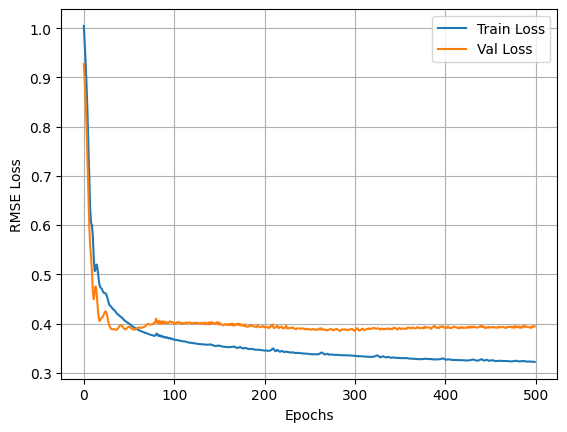

In [292]:
plt.plot(epochs_list,train_loss_list,label='Train Loss')
plt.plot(epochs_list,val_loss_list,label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('RMSE Loss')
plt.grid()
plt.legend()
plt.show()

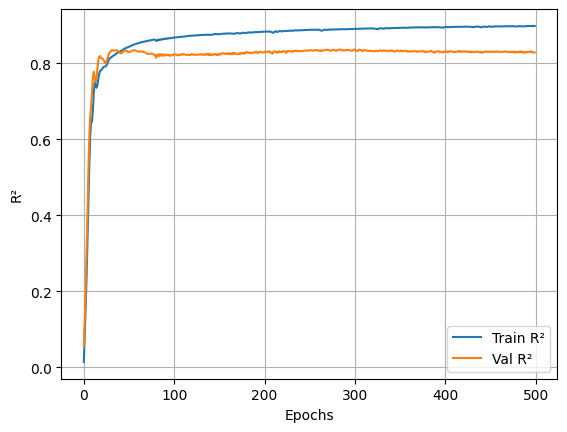

In [293]:
plt.plot(epochs_list,trainr2,label='Train R\u00b2')
plt.plot(epochs_list,valr2,label='Val R\u00b2')
plt.xlabel('Epochs')
plt.ylabel('R\u00b2')
plt.grid()
plt.legend()
plt.show()

In [294]:
X_non_zero = X[idx_y_nonzero]
scaled_X_non_zero = scalerX.transform(X_non_zero)
torch_scaled_X_non_zero = torch.from_numpy(scaled_X_non_zero).type(torch.float32).to(device)
with torch.inference_mode():
    predictions = reg_model(torch_scaled_X_non_zero)
model_pred = predictions.detach().cpu().numpy()

transformed_model_pred = scalerY.inverse_transform(model_pred)
transformed_model_pred.shape

(259, 1)

## MODEL OVER ALL PERFORMANCE

In [295]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
a = np.sqrt(mean_squared_error(y_non_zero,transformed_model_pred))
b = mean_absolute_error(y_non_zero,transformed_model_pred)
c = mean_squared_error(y_non_zero,transformed_model_pred)
d = r2_score(y_non_zero,transformed_model_pred)

In [296]:
print(f"RMSE: {a:.4f}")
print(f"MAE: {b:.4f}")
print(f"MSE: {c:.4f}")
print(f"R\u00b2: {d:.4f}")

RMSE: 2.7185
MAE: 1.9110
MSE: 7.3903
R²: 0.8832


In [297]:

with torch.inference_mode():
    predictions = reg_model(torch_X_train)
ytrain_pred = predictions.detach().cpu().numpy()


transformed_ytrain_pred = scalerY.inverse_transform(ytrain_pred)
transformed_ytrain_pred.shape
transformed_ytrain_act = scalerY.inverse_transform(torch_y_train.detach().cpu().numpy())
transformed_ytrain_act.shape

(194, 1)

Text(0.01, 0.99, '(a)')

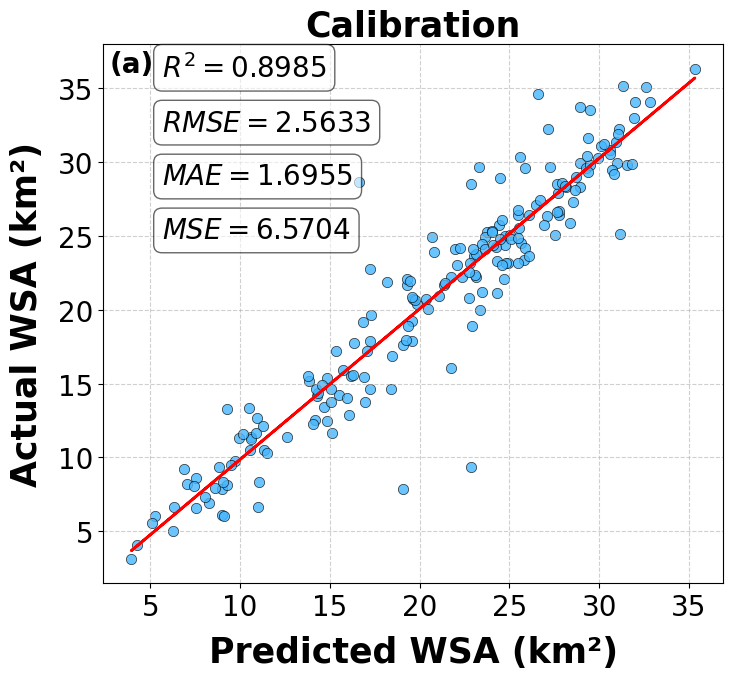

In [298]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


x = transformed_ytrain_pred
y = transformed_ytrain_act


x = x.reshape(-1, 1)


model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)


r2 = r2_score(y, x)
rmse = np.sqrt(mean_squared_error(y, x))
mae = mean_absolute_error(y, x)
mse = mean_squared_error(y, x)


plt.figure(figsize=(8, 7))

plt.rcParams["font.family"] = "DejaVu Sans"
plt.scatter(x, y,color='#45b6fe', s=55, alpha=0.8, edgecolors='black', linewidth=0.5)
plt.plot(x, y_pred, color='red', linewidth=2, linestyle='solid')

text_props = dict(facecolor='white', alpha=0.6, edgecolor='black', boxstyle="round,pad=0.3")
plt.text(0.095, 0.94, f'$R^2 = {r2:.4f}$', transform=plt.gca().transAxes, fontsize=20, bbox=text_props)
plt.text(0.095, 0.84, f'$RMSE = {rmse:.4f}$', transform=plt.gca().transAxes, fontsize=20, bbox=text_props)
plt.text(0.095, 0.74, f'$MAE = {mae:.4f}$', transform=plt.gca().transAxes, fontsize=20, bbox=text_props)
plt.text(0.095, 0.64, f'$MSE = {mse:.4f}$', transform=plt.gca().transAxes, fontsize=20, bbox=text_props)

plt.xlabel('Predicted WSA (km²)', fontsize=25, fontweight='bold', labelpad=10)
plt.ylabel('Actual WSA (km²)', fontsize=25, fontweight='bold', labelpad=10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.grid(True, linestyle='--', alpha=0.6)
plt.title('Calibration',fontsize=25, fontweight='bold')

plt.text(0.01, 0.99, '(a)', transform=plt.gca().transAxes,
         fontsize=20, fontweight='bold', va='top', ha='left')
# Display the plot
# plt.savefig(r'calibration_scatter_fnn.jpg',dpi=600)


In [299]:
with torch.inference_mode():
    predictions = reg_model(torch_X_test)
ytest_pred = predictions.detach().cpu().numpy()


transformed_ytest_pred = scalerY.inverse_transform(ytest_pred)
transformed_ytest_act = scalerY.inverse_transform(torch_y_test.detach().cpu().numpy())


Text(0.01, 0.99, '(b)')

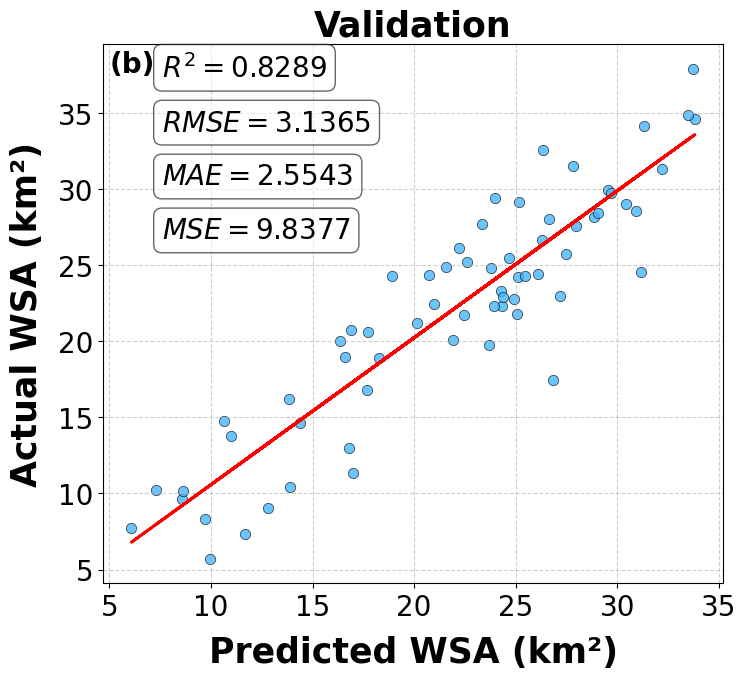

In [300]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


x = transformed_ytest_pred
y = transformed_ytest_act


x = x.reshape(-1, 1)


model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)


r2 = r2_score(y, x)
rmse = np.sqrt(mean_squared_error(y, x))
mae = mean_absolute_error(y, x)
mse = mean_squared_error(y, x)


plt.figure(figsize=(8, 7))
plt.scatter(x, y,color='#45b6fe', s=55, alpha=0.8, edgecolors='black', linewidth=0.5)
plt.plot(x, y_pred, color='red', linewidth=2, linestyle='solid')


text_props = dict(facecolor='white', alpha=0.6, edgecolor='black', boxstyle="round,pad=0.3")
plt.text(0.095, 0.94, f'$R^2 = {r2:.4f}$', transform=plt.gca().transAxes, fontsize=20, bbox=text_props)
plt.text(0.095, 0.84, f'$RMSE = {rmse:.4f}$', transform=plt.gca().transAxes, fontsize=20, bbox=text_props)
plt.text(0.095, 0.74, f'$MAE = {mae:.4f}$', transform=plt.gca().transAxes, fontsize=20, bbox=text_props)
plt.text(0.095, 0.64, f'$MSE = {mse:.4f}$', transform=plt.gca().transAxes, fontsize=20, bbox=text_props)


plt.xlabel('Predicted WSA (km²)', fontsize=25, fontweight='bold', labelpad=10)
plt.ylabel('Actual WSA (km²)', fontsize=25, fontweight='bold', labelpad=10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.grid(True, linestyle='--', alpha=0.6)
plt.title('Validation',fontsize=25, fontweight='bold')
# Show legend
# plt.legend(fontsize=12, loc='upper left')
plt.text(0.01, 0.99, '(b)', transform=plt.gca().transAxes,
         fontsize=20, fontweight='bold', va='top', ha='left')
# Display the plot
# plt.savefig(r'Validation_scatter_fnn.jpg',dpi=600)

In [301]:
torch_X = torch.from_numpy(scaled_X_non_zero).type(torch.float32).to(device)
scaled_y_non_zero
torch_y = torch.from_numpy(scaled_y_non_zero).type(torch.float32).to(device)
with torch.inference_mode():
    predictions = reg_model(torch_X)
y_pred = predictions.detach().cpu().numpy()


transformed_y_pred = scalerY.inverse_transform(y_pred)
transformed_y_act = scalerY.inverse_transform(torch_y.detach().cpu().numpy())

Text(0.01, 0.99, '(c)')

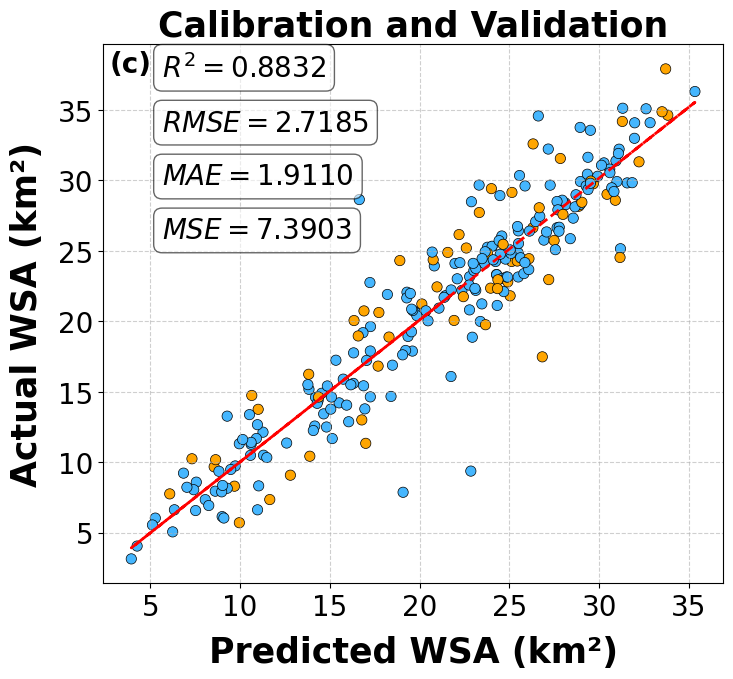

In [302]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

x = transformed_y_pred
y = transformed_y_act

x = x.reshape(-1, 1)


model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)


r2 = r2_score(y, x)
rmse = np.sqrt(mean_squared_error(y, x))
mae = mean_absolute_error(y, x)
mse = mean_squared_error(y, x)


plt.figure(figsize=(8, 7))


color1 = ['#45b6fe'] * len(y_non_zero)  # Default: Blue
for idx in test_idx:
    color1[idx] = 'orange'  # Orange for specific indices


plt.rcParams["font.family"] = "DejaVu Sans"

plt.scatter(x, y, c=color1, s=55, edgecolors='black', linewidth=0.5,)
plt.plot(x, y_pred, color='red', linewidth=2, linestyle='dashed')


text_props = dict(facecolor='white', alpha=0.6, edgecolor='black', boxstyle="round,pad=0.3")
plt.text(0.095, 0.94, f'$R^2 = {r2:.4f}$', transform=plt.gca().transAxes, fontsize=20, bbox=text_props)
plt.text(0.095, 0.84, f'$RMSE = {rmse:.4f}$', transform=plt.gca().transAxes, fontsize=20, bbox=text_props)
plt.text(0.095, 0.74, f'$MAE = {mae:.4f}$', transform=plt.gca().transAxes, fontsize=20, bbox=text_props)
plt.text(0.095, 0.64, f'$MSE = {mse:.4f}$', transform=plt.gca().transAxes, fontsize=20, bbox=text_props)

plt.xlabel('Predicted WSA (km²)', fontsize=25, fontweight='bold', labelpad=10)
plt.ylabel('Actual WSA (km²)', fontsize=25, fontweight='bold', labelpad=10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Calibration and Validation',fontsize=25, fontweight='bold')

plt.grid(True, linestyle='--', alpha=0.6)


# plt.legend(fontsize=12, loc='lower right')
plt.text(0.01, 0.99, '(c)', transform=plt.gca().transAxes,
         fontsize=20, fontweight='bold', va='top', ha='left')
# Display the plot
# plt.savefig(r'calibration&validation_scatter_fnn.jpg',dpi=600)


In [303]:
# X_non_zero = X[idx_y_nonzero]
# scaled_X_non_zero = scalerX.transform(X_non_zero)
torch_scaled_X = torch.from_numpy(scaled_X).type(torch.float32).to(device)
with torch.inference_mode():
    predictions = reg_model(torch_scaled_X)
model_pred = predictions.detach().cpu().numpy()


transformed_pred = scalerY.inverse_transform(model_pred)
transformed_pred.shape

(384, 1)

In [304]:
pred_fnn = pd.DataFrame({
    'Predicted_Area': transformed_pred.reshape(384)
})

In [305]:
filled_fnn = pd.DataFrame({
    'Predicted_Area': transformed_pred.reshape(384)
})
filled_fnn.loc[idx_y_nonzero, "Predicted_Area"] = y_non_zero.astype('float32').reshape(-1)

In [306]:
import pandas as pd
import numpy as np
test_idx = np.array([ 66,  45,   9,  73, 137, 104, 206, 229, 125, 212,  84,  33, 250,
        68,  46, 108,   6,  30, 101,  55,  24, 178, 205, 180, 168,  15,
       132, 227, 237, 143,  19, 152,  67, 200,  10, 109,  60, 119,  92,
        25,  75,  18, 148, 241, 190, 176, 257, 185, 184,  90, 165,  16,
       211, 141, 115,  77, 181,  38, 139, 236, 228, 251,  82, 225, 111])

a = pd.read_excel(r"/kaggle/input/tc-data/TC_Data_xl.xlsx","lagged")
aa = pd.read_excel(r"/kaggle/input/tc-data/TC_Data_xl.xlsx",'wo_lag')
date = pd.to_datetime(aa['Date'],dayfirst=True)
a['wa'] = a['wa'].replace(0, np.nan)
test_point = []
for i in range(len(test_idx)):
    point = y_non_zero[test_idx[i]][0]

    idx = np.where(np.isclose(pred_vals, point, rtol=1e-6, atol=1e-8))[0]

    if len(idx) == 0:
        continue

    test_point.append(idx[0])


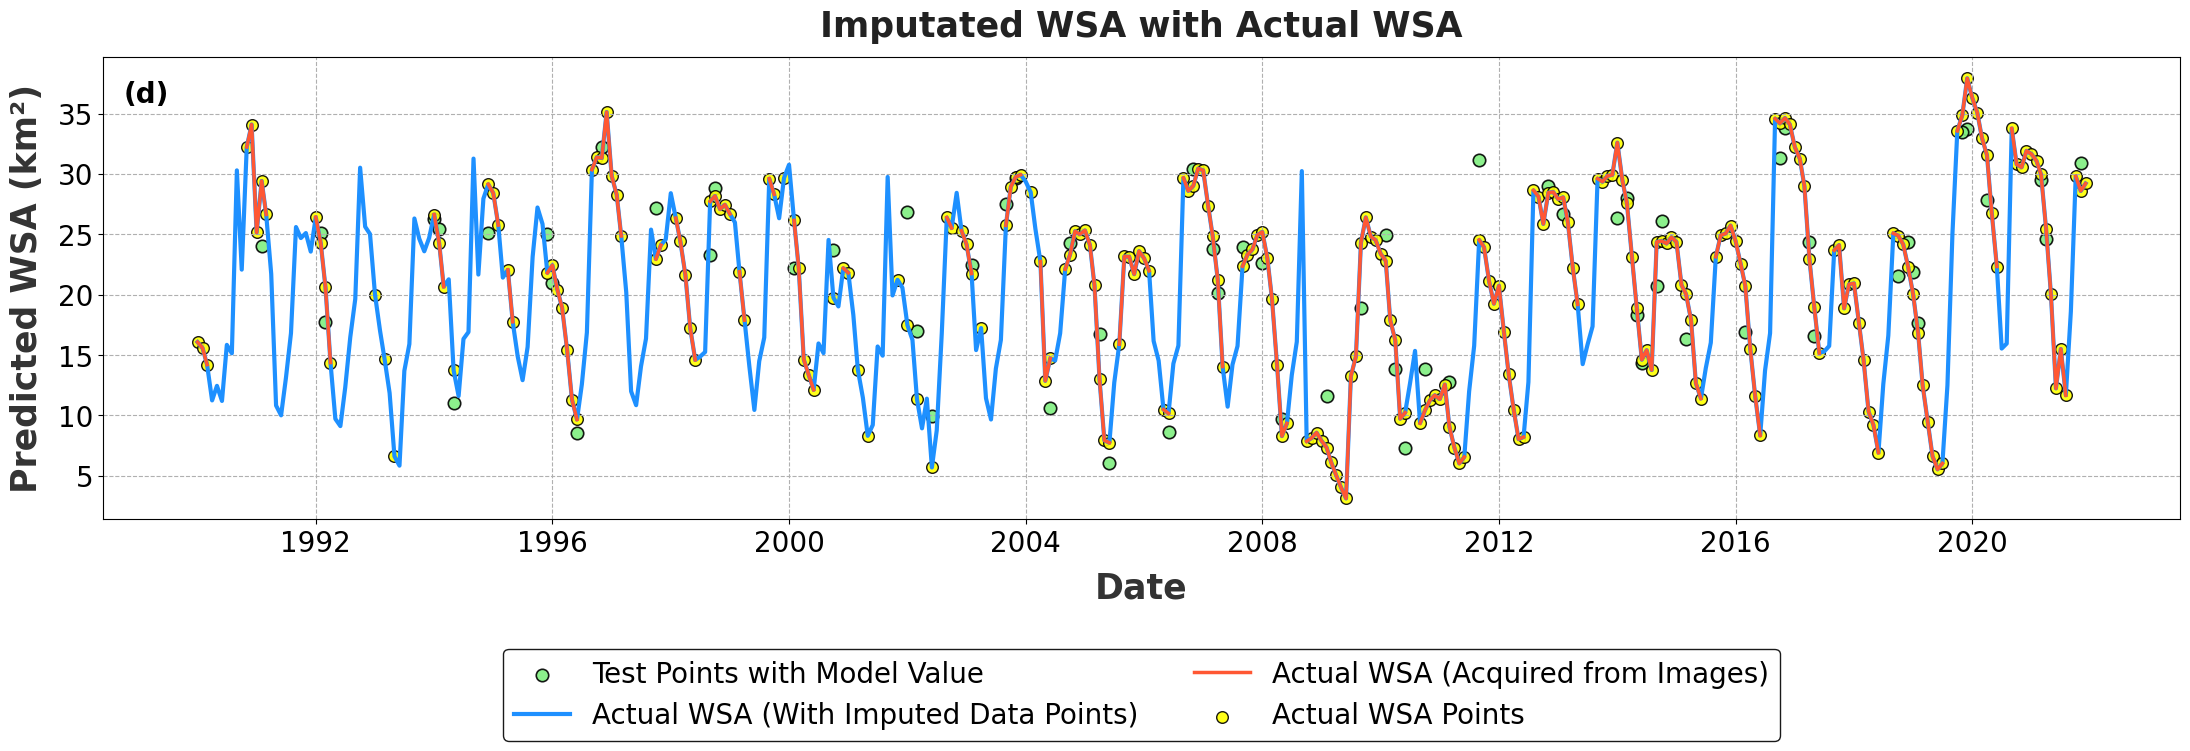

In [307]:
import matplotlib.pyplot as plt

# Define colors, edge colors, and alpha values properly

# Create figure with an improved background color
plt.figure(figsize=(22, 8))

# Scatter plot with fixed white color, alpha, and black edges

test_dates = [date[i] for i in test_point]
test_preds = [pred_fnn['Predicted_Area'][i] for i in test_point]

# Now plot just those
plt.scatter(test_dates, test_preds, c='#80ef80', edgecolors='black', s=80, alpha=0.9, linewidth=1.2, label='Test Points with Model Value')
plt.plot(date, filled_fnn['Predicted_Area'], color='#1E90ff', linestyle='solid', linewidth=3, label='Actual WSA (With Imputed Data Points)')
# Improved missing data visualization
plt.plot(date, a['wa'], color='#FF5733', linestyle='solid', linewidth=2.5, label='Actual WSA (Acquired from Images)')  # Aesthetic red-orange
plt.scatter(date, a['wa'], color='yellow', edgecolors='black', s=70, alpha=0.9, label='Actual WSA Points')  # Bright blue for contrast

# Improved imputed data visualization
  # Elegant deep purple

# Add grid with a softer color
plt.grid(True, linestyle='--', color='#B0B0B0')

# Improve labels and title
plt.xlabel("Date", fontsize=25, fontweight='bold', color='#333333', labelpad=10)
plt.ylabel("Predicted WSA (km²)", fontsize=25, fontweight='bold', color='#333333', labelpad=10)
plt.title("Imputated WSA with Actual WSA", fontsize=25, fontweight='bold', color='#222222', pad=15)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
# Improve legend readability
plt.legend(
    fontsize=20,
    loc='upper center',
    frameon=True,
    facecolor='white',
    edgecolor='black',
    framealpha=0.9,
    ncol=2,
    bbox_to_anchor=(0.5, -0.25)  # <-- outside, below the axes
)
plt.tight_layout()
# Show the plot
plt.text(0.01, 0.95, '(d)', transform=plt.gca().transAxes,
         fontsize=20, fontweight='bold', va='top', ha='left')
plt.savefig(r'line_fnn.jpg',dpi=600)
